<a href="https://colab.research.google.com/github/VarunSreenivasan16/Entity-Recognition/blob/main/Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Answers to questions in the email

Q1: Exploratory Data Analysis

ANS: I performed Named Entity Recognition (NER) using the datasets provided to me by Infrrd.

I also performed addition EDA such as text statistics, Ngram exploration, and sentiment analysis on the train set


Q2: How many solutions you can think of and why are you choosing your version of the solution

I thought of three solutions for NER as there are three standard libraries to do NER: 

-Stanford NER
-spaCy
-NLTK

I made use of spaCy because I read that it is the fastest and most accurate. 


Q3: How do you come to the right metric?

I'm assuming that this question corresponds to evaluation metric. 

Since, I don't know the ground truth. I'll just mention the metrics that could be used to evaluate the 
performance of the NER model I created.

1) accuracy (general)
2) precision, recall, F1
3) Confusion Matrix
'''

In [ ]:
'''
A note about organization of files and folders.

Folder 1: Train
      
   File 1: train.txt - the training file provided to me by Infrrd.

   File 2: train-1.txt - the cleaned version of train.txt. Reason for cleaning explained below.

   File 3: ner-corpus.json - the json file containing sentences and corresponding entities for a sentence. 
                             The intermediate step in creating data in spaCy training format.
                          

Folder 2: Model

   This folder contains sub-folders and files corresponding to the spaCy ner model that I created below. 


Folder 3: Test
   
   File 1: test.txt - the test file provided to me by Infrrd.

   File 2: test-1.txt - the cleaned version of test.txt.

   File 3: test-parsed.txt - the parsed version of test-1.txt. Contains the sentences.


Folder 4: Output
      
   File 1: test-output.txt - the final output file containing a mapping of senetences to the predicted entities for the respective 
                             sentence.

                             For example: 
                             Sentence: & gt ; * Police last week evacuated 80 villagers from Waltengoo Nar where dozens 
                                        were killed after a series of avalanches hit the area in 2005 in the south of the territory . 
                              
                             Entities [('Waltengoo', 'B-location'), ('Nar', 'I-location')]


Folder 5: Additional-EDA

   File 1: train-sentences.txt: a file that contains only the sentences in train-1.txt and not the BILOU symbols. Used to do 
                                additional EDA. 
'''

In [4]:
#Importing Libraries
import json
import spacy
import random
from spacy.util import minibatch, compounding
from pathlib import Path

In [ ]:
'''
PART 1: DATA CLEANING and PREPARATION
'''

In [ ]:
'''
The original train.txt (given to me by Infrrd) is cleaned to ensure only english characters are present. This file is train-1.txt.

The next step is to create data in the spacy training format.
'''

In [21]:
'''
In this step of Part 1, sentences are generated from train-1.txt and corresponding entities are also added. 

In train-1.txt, a blank line separates one sentence from another. 

This is an intermediate step towards creating data in the spacy format. 

Input: train-1.txt
Output: ner-corpus.json
'''
def delim_to_json(input_path,output_path):
    try:
        #Files
        fread = open(input_path,'r')
        fwrite = open(output_path, 'w')
        
        lines = fread.readlines()
         
        #data structures
        labels = {}
        data = {}
        annotations = []

        #variables
        string = ''
        st_start = 0

        for line in lines:
          #blank line found
          if len(line) <= 2:

             list_label = []
             data['content'] = string
             string = ''

             for entities in list(labels.keys()):
                 for i in range(len(labels[entities])):
                     if(labels[entities][i]['text'] != ''):
                        val = [entities, labels[entities][i]]
                        for j in range(i+1, len(labels[entities])):
                            if(labels[entities][i]['text'] == labels[entities][j]['text']):
                                dictionary = {}
                                dictionary['start'] = labels[entities][j]['start']
                                dictionary['end'] = labels[entities][j]['end']
                                dictionary['text'] = labels[entities][i]['text']
                                val.append(dictionary)
                                labels[entities][j]['text'] = ''
                        list_label.append(val)
               
             for ents in list_label:
                  temp_dict = {}
                  temp_dict['label'] = [ents[0]]
                  temp_dict['points'] = ents[1:]
                  annotations.append(temp_dict)
             data['annotation'] = annotations
             annotations = []
             json.dump(data, fwrite)
             fwrite.write('\n')
             st_start = 0
             labels = {}
             data = {}
          
          else:
              word, entity = line.split('\t')
              string += word
              string += " "
              entity = entity[:len(entity)-1]
 
              if len(entity) != 1:
                 dictionary = {}
                 dictionary['text'] = word
                 dictionary['start'] = st_start
                 dictionary['end'] = st_start + len(word) - 1

                 try:
                    labels[entity].append(dictionary)
                 except:
                    labels[entity] = []
                    labels[entity].append(dictionary)
                 
              st_start += len(word) + 1

    except Exception as e:
        logging.exception("Unable to process file" + "\n")
        return None

In [23]:
#call the above function
delim_to_json('Train/train-1.txt','Train/ner-corpus.json')

In [34]:
'''
This function is used to convert from the json format to the spacy training format.

Input: ner-corpus.json

Output: Data in the format below (Note: entity labels are determined by labels in train-1.txt)

train_data = [
    ("Uber blew through $1 million a week", [(0, 4, 'ORG')]),
    ("Android Pay expands to Canada", [(0, 11, 'PRODUCT'), (23, 30, 'GPE')]),
    ("Spotify steps up Asia expansion", [(0, 8, "ORG"), (17, 21, "LOC")]),
    ("Google Maps launches location sharing", [(0, 11, "PRODUCT")]),
    ("Google rebrands its business apps", [(0, 6, "ORG")]),
    ("look what i found on google!", [(21, 27, "PRODUCT")])]
'''
def convert_json_to_spacy(JSON_FilePath):
  
    try:
        lines= None
        training = []

        f = open(JSON_FilePath, 'r')
        lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:

                labels = annotation['label']
                point = annotation['points'][0]
                
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    #spacy index format is [start, end)
                    entities.append((point['start'], point['end'] + 1 ,label))


            training.append((text, {"entities" : entities}))

        return training
    except Exception as e:
        logging.exception("Unable to process " + JSON_FilePath + "\n")
        return None

In [35]:
#call function above
TRAIN_DATA = convert_json_to_spacy('Train/ner-corpus.json')

In [ ]:
'''
PART 2: TRAINING
'''

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.pipe_names

['tagger', 'parser', 'ner']

In [ ]:
ner = nlp.get_pipe("ner")

In [ ]:
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [ ]:
disable_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

In [ ]:
#train and update nlp model
with nlp.disable_pipes(*disable_pipes):
  optimizer = nlp.resume_training()

  for iteration in range(100):

    random.shuffle(TRAIN_DATA)
    losses = {}

    batches = minibatch(TRAIN_DATA, size = compounding(1.0,4.0,1.001))

    for batch in batches:
      text, annotation = zip(*batch)
      nlp.update(
          text,
          annotation,
          drop = 0.5,
          losses = losses,
          sgd = optimizer
      )
    print("Iteration " + str(iteration))
    print("losses:" ,losses)

Iteration 0
losses: {'ner': 46975.76784088991}
Iteration 1
losses: {'ner': 45987.00744654691}
Iteration 2
losses: {'ner': 46024.81522979578}
Iteration 3
losses: {'ner': 45622.14568318251}
Iteration 4
losses: {'ner': 45492.71042445501}
Iteration 5
losses: {'ner': 45337.95611837309}
Iteration 6
losses: {'ner': 45113.450839146884}
Iteration 7
losses: {'ner': 45091.20746317874}
Iteration 8
losses: {'ner': 44845.94547716535}
Iteration 9
losses: {'ner': 44839.97937214525}
Iteration 10
losses: {'ner': 44778.07153133767}
Iteration 11
losses: {'ner': 45069.3844305605}
Iteration 12
losses: {'ner': 44919.690052925114}
Iteration 13
losses: {'ner': 44982.92301614096}
Iteration 14
losses: {'ner': 44651.14564066679}
Iteration 15
losses: {'ner': 44634.42326130738}
Iteration 16
losses: {'ner': 44841.89755041746}
Iteration 17
losses: {'ner': 44588.90600523059}
Iteration 18
losses: {'ner': 44682.30255393431}
Iteration 19
losses: {'ner': 44709.09909917239}
Iteration 20
losses: {'ner': 44741.000192700085}


In [ ]:
saved = nlp

In [ ]:
saved.to_disk('.')

In [39]:
mod = spacy.load('Model/')

In [ ]:
'''
PART 3: GENERATING TEST RESULTS
'''

In [ ]:
'''
Like the train.txt, cleaning is done for the original test.txt and this new file is test-1.txt
'''

In [40]:
'''
This function parses the cleaned text data to combine words and generate sentences. 
Sentences are separated by the blank line in the test file.

Input: test-1.txt
Output: test-parsed.txt
'''
def parse_test(input_path,output_path):
    
    f=open(input_path,'r', encoding= 'cp1252') # input file
    fp=open(output_path, 'w') # output file
    Lines = f.readlines()
    
    s = ''
    for line in Lines:
    
        if(line != '\n'):
            s += line[0:len(line)-1]
            s+= ' '
        else:
          
            fp.write(s)
            fp.write('\n')
            s = ''
       
    fp.close()
        

In [41]:
#Call the above function
parse_test("Test/test-1.txt", 'Test/test-parsed.txt')

In [42]:
'''
this function performs entity recognition on each sentence.

Input: test-parsed.txt
Output: test-parsed.txt
'''
def entity_recognition(input_path, output_path):

    f=open(input_path,'r', encoding= 'cp1252')
    fp=open(output_path, 'w') #output file
    Lines = f.readlines()

    for line in Lines:
        fp.write("Sentence: " + line)
        
        doc = mod(line)
        l = [(ent.text, ent.label_) for ent in doc.ents]
        st = 'Entities ' + str(l) 
        fp.write(st)
        fp.write('\n')
        fp.write('\n')
       

In [43]:
#Call the above function
entity_recognition('Test/test-parsed.txt', 'Output/test-output.txt')

In [ ]:
'''
PART 4: ADDITIONAL EDA
'''

In [94]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

In [95]:
fp = open('Additional-EDA/train-sentences.txt', 'w')

for text, _ in TRAIN_DATA:
     fp.write(text)
     fp.write('\n')
fp.close()

In [96]:
df = pd.read_csv('Additional-EDA/train-sentences.txt', sep = '\t', header = None)
df.columns = ["Sentence"]

In [ ]:
'''
Text Statistics
'''

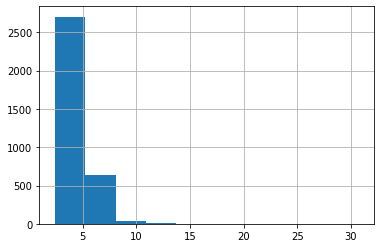

In [98]:
#Average Word Length in each sentence

df['Sentence'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [ ]:
#Finding the most popular stopwords

nltk.download('stopwords')
stop_set=set(stopwords.words('english'))

corpus = []

split_set = df['Sentence'].str.split()
split_set  = split_set.values.tolist()
corpus=[word for i in split_set for word in i]

dictionary =defaultdict(int)
for word in corpus:
    if word in stop_set:
        dictionary[word]+=1

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


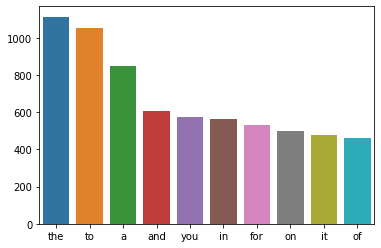

In [100]:
counter=Counter(dictionary)
popular=counter.most_common()
x, y=[], []
for word,count in popular[:10]:  
    x.append(word)
    y.append(count)
            
sns.barplot(x,y)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


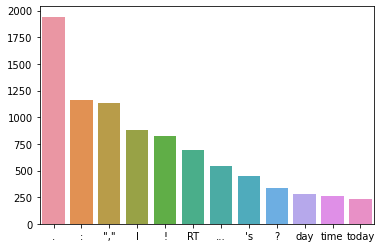

In [101]:
#Finding most popular words besides stopwords

counter=Counter(corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:30]:
    if (word not in stop_set):
        x.append(word)
        y.append(count)
        
sns.barplot(x,y)


In [102]:
#Analyzing N-grams
def plot_barchart_N_grams(text, n=None):
    
    stop_set=set(stopwords.words('english'))

    upd = text.str.split()
    conv =upd.values.tolist()
    corpus=[word for i in new for word in i]

    
    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

def get_top_ngram(corpus, n=None):
    vector = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    b_o_w = vector.transform(corpus)
    word_sum = b_o_w.sum(axis=0) 
    freq_words = [(word, word_sum[0, idx]) 
                    for word, idx in vector.vocabulary_.items()]
    freq_words =sorted(freq_words, key = lambda x: x[1], reverse=True)
    return freq_words[:10]


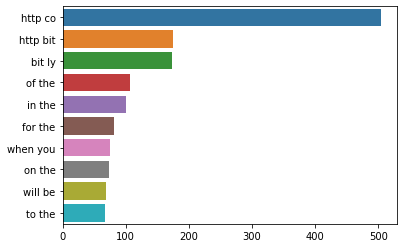

In [103]:
#Bigram Model
plot_top_ngrams_barchart(df['Sentence'],2)

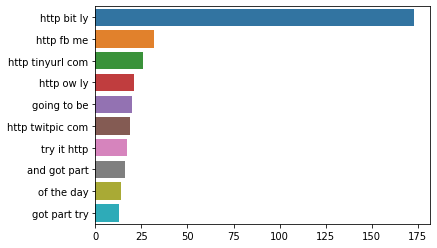

In [104]:
#Trigram Model
plot_top_ngrams_barchart(df['Sentence'],3)

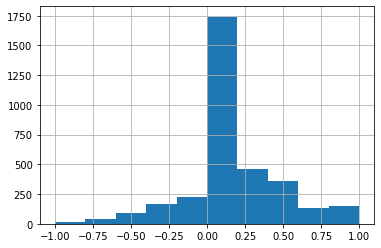

In [105]:
#Sentiment Analysis

#polarity is a floating-point number that lies in the range [-1,1] where 1 is a positive statement and -1 is a negative statement.
def polarity(text):
        return TextBlob(text).sentiment.polarity 

def plot_polarity_histogram(text):
         
    polarity_score =text.apply(lambda x : polarity(x))
    polarity_score.hist()

plot_polarity_histogram(df['Sentence'])